> The Basic Iterative Method (BIM) implementation reference to this article: https://www.neuralception.com/adversarialexamples-bim/

> This attack method comes from Adversarial examples in the physical world paper.

# Basic Iterative Method (BIM)

The Basic Iterative Method (BIM), as described in "Adversarial Examples in the Physical World," is an extension of the Fast Gradient Sign Method (FGSM). Unlike FGSM, which takes a single large step, BIM employs an iterative approach, applying FGSM multiple times to an image. Each iteration modifies the image's pixel values by a small step size α, with the aim of creating a more controlled and subtle adversarial perturbation.

## Iterative Approach

The iterative nature of BIM allows for more precise control over the perturbation, but it also means that the method is slower compared to single-step techniques like FGSM. Here’s how the BIM process works:

1. **Initialization**: Start with a clean image `X` at iteration `N=0`:

   ```
   X̃0 = X
   ```

2. **Adversarial Perturbation**:
   For each iteration, modify the image using a formula similar to FGSM:

   ```
   X'1 = X̃0 + α * sign(∇XJ(X̃0, Y_true))
   ```

   Where `α` is the step size and `∇XJ(X̃0, Y_true)` is the gradient of the loss with respect to the image.

3. **Clipping**:
   After applying the perturbation, clip the pixel values to ensure they remain within a specific range:

   ```
   X̃1 = min(255, X + ε, max(0, X - ε, X'1))
   ```

   This step ensures that all pixel values stay within the bounds defined by `ε`, limiting the maximum perturbation for each pixel.

4. **Repeat**:
   These steps are repeated for `N` iterations to refine the adversarial example incrementally.

## Hyperparameters

In their study, the authors suggest specific values for hyperparameters based on their experimental findings:

- **Step Size (α)**: `α = 1/255`
- **Number of Iterations**: Calculated as the minimum of either `4 + ε/α` or `1.25 * ε/α`

The choice of `α` at one pixel intensity value and the method to determine the number of iterations are designed to allow each pixel sufficient steps to achieve maximum adversarial impact within the bounds of `ε`.



In [ ]:
! pip install ultralytics

The YOLOV8 backbone is for **object detection**. We need to get the output from the backbone so that we know how YOLOV8 classifies the object.

In [30]:
import torch
import torch.nn as nn
from ultralytics import YOLO
from torchvision import transforms
from PIL import Image



# Step 1: Load trained YOLOv8 model
model = YOLO('train/weights/best.pt')
image_path = 'stop.png'

# Step 2: Extract the backbone (CSPDarknet53)
backbone = model.model.model[:10]
labels = torch.tensor([22])

num_classes = 29
sample_image = torch.randn(1, 3, 416, 416)  # Adjust size if necessary
sample_output = backbone(sample_image)
output_channels = sample_output.shape[1]
classify_model = nn.Sequential(
    backbone,  # Use the CSPDarknet53 backbone
    nn.AdaptiveAvgPool2d((1, 1)),  # Global Average Pooling to reduce to (batch_size, channels, 1, 1)
    nn.Flatten(),  # Flatten to (batch_size, channels)
    nn.Linear(in_features=output_channels, out_features=num_classes)  # Linear layer for classification
)

preprocess = transforms.Compose([
    transforms.Resize((416, 416)),  # Resize to 416x416
    transforms.ToTensor(),          # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
])

image = Image.open(image_path).convert("RGB")  # Load image and ensure it's in RGB format
image = preprocess(image).unsqueeze(0)  # Apply preprocessing and add batch dimension

## Implementation

This section would include specific code or algorithmic steps to implement BIM based on the above mathematical formulas and methodological description.

**Epsilon (ε)**: Epsilon controls the maximum perturbation. Larger values of epsilon will allow more significant changes to each pixel, resulting in a more pronounced adversarial effect but potentially losing subtlety. 

**Alpha (α)**: Alpha controls the step size for each iteration. Ideally, α should be small enough to ensure each step is subtle but large enough to converge within a reasonable number of iterations.

In [31]:
import torch
import torch.nn as nn

def bim_attack(model, images, labels, epsilon, alpha, num_iterations):
    """
    Perform the Basic Iterative Method (BIM) attack on the input images.

    Args:
        model: The model to attack.
        images: The input images to perturb.
        labels: True labels for the input images.
        epsilon: Maximum allowable perturbation.
        alpha: Step size for each iteration.
        num_iterations: Number of iterations to perform.

    Returns:
        perturbed_image: The adversarially perturbed image.
    """
    # Clone the input images to avoid modifying the original data
    perturbed_image = images.clone().detach()
    perturbed_image.requires_grad = True

    for _ in range(num_iterations):
        # Zero the gradients
        model.zero_grad()
        
        # Forward pass
        outputs = model(perturbed_image)
        
        # Compute the loss
        loss = nn.CrossEntropyLoss()(outputs, labels)
        
        # Backward pass to compute gradients
        loss.backward()
        
        # Perform a step similar to FGSM
        grad_sign = perturbed_image.grad.data.sign()
        perturbed_image = perturbed_image + alpha * grad_sign
        
        # Clip the adversarial image to maintain the epsilon constraint
        perturbed_image = torch.max(torch.min(perturbed_image, images + epsilon), images - epsilon)
        
        # Clamp to ensure pixel values are within the valid range [0, 1]
        perturbed_image = torch.clamp(perturbed_image, 0, 1)
        
        # Detach gradients to avoid accumulation
        perturbed_image = perturbed_image.clone().detach()
        perturbed_image.requires_grad = True

    return perturbed_image

# Example usage of BIM attack
# epsilon = 0.1
epsilon = 0.2
# epsilon = 0.3
# alpha = 1 / 255
# alpha = 2/255
alpha = 3/255
num_iterations = int(min(4 + epsilon / alpha, 1.25 * epsilon / alpha))
# num_iterations = int(min(10 + epsilon / alpha, 1.5 * epsilon / alpha))


bim_perturbed_image = bim_attack(classify_model, image, labels, epsilon, alpha, num_iterations)

# Use YOLO model to get output on adversarial image
# bim_boxes, bim_scores, bim_labels = get_yolo_output(model, bim_perturbed_image)


Get YOLOv8 output for both the original image and the BIM perturbed image.

In [32]:
def get_yolo_output(model, image):
    results = model(image)
    return results[0].boxes.xyxy, results[0].boxes.conf, results[0].boxes.cls

image = torch.clamp(image, 0, 1)
boxes, scores, labels = get_yolo_output(model, image)
bim_boxes, bim_scores, bim_labels = get_yolo_output(model, bim_perturbed_image)



0: 416x416 1 Stop_Sign, 69.8ms
Speed: 0.0ms preprocess, 69.8ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 416)

0: 416x416 1 Stop_Sign, 64.4ms
Speed: 0.0ms preprocess, 64.4ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 416)


Plot the orignal image and the BIM perturbed image, and get the perturbation by making a difference between them.

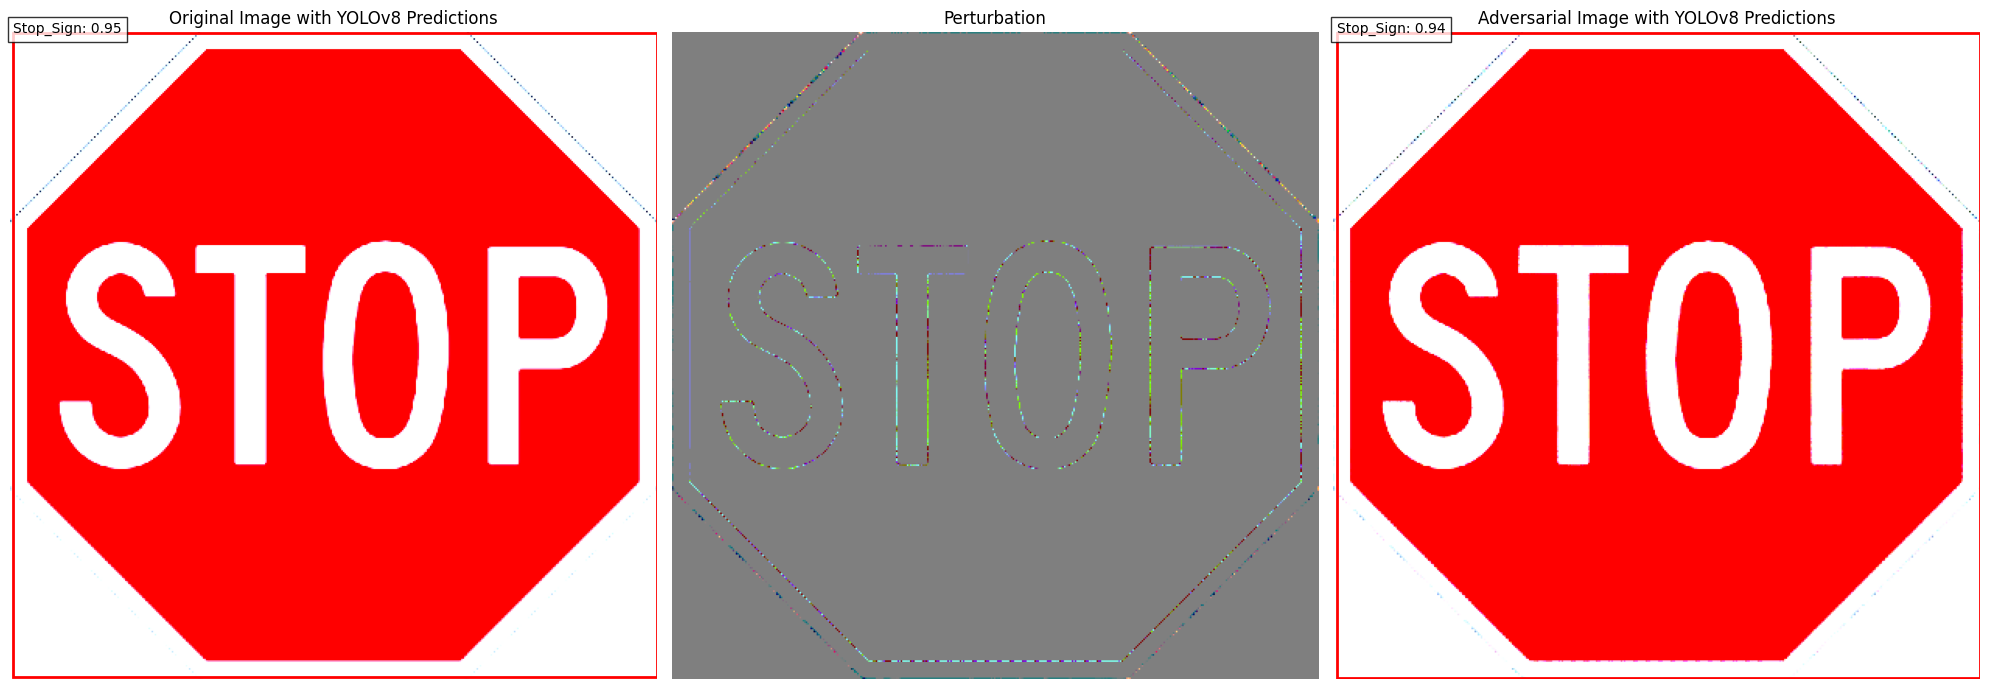

In [33]:
import matplotlib.pyplot as plt

def plot_boxes(ax, boxes, scores, labels, title, image_tensor):
    # Detach, remove batch dimension, permute to (height, width, channels), and convert to NumPy
    ax.imshow(image_tensor.squeeze(0).permute(1, 2, 0).cpu().detach().numpy())
    for box, score, label in zip(boxes, scores, labels):
        x1, y1, x2, y2 = box.detach().cpu().numpy()
        rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor='r', linewidth=2)
        ax.add_patch(rect)
        ax.text(x1, y1, f"{model.names[int(label)]}: {score:.2f}", bbox=dict(facecolor='white', alpha=0.8))
    ax.set_title(title)
    ax.axis('off')

fig, axs = plt.subplots(1, 3, figsize=(20, 10))

# Original image with predictions
plot_boxes(axs[0], boxes, scores, labels, "Original Image with YOLOv8 Predictions", image)

# Perturbation
perturbation = (bim_perturbed_image - image).squeeze().permute(1, 2, 0).cpu().detach().numpy()
perturbation = (perturbation - perturbation.min()) / (perturbation.max() - perturbation.min())
axs[1].imshow(perturbation)
axs[1].set_title("Perturbation")
axs[1].axis('off')

# Adversarial image with predictions
plot_boxes(axs[2], bim_boxes, bim_scores, bim_labels, "Adversarial Image with YOLOv8 Predictions", bim_perturbed_image)

plt.tight_layout()
plt.show()
